In [1]:
from SingleUESTA.network import Network
from SingleUESTA.node import Node
from SingleUESTA.link import Link
from SingleUESTA.path import Path
from SingleUESTA.od import OD
from SingleUESTA import utils



net = Network("/Users/alfredzhong/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/GeorgiaTech/Courses/25Fall/8803/Team2/SiouxFalls/SiouxFalls_net.tntp",
              "/Users/alfredzhong/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/GeorgiaTech/Courses/25Fall/8803/Team2/SiouxFalls/SiouxFalls_trips.tntp")


In [2]:

def run_assignment(solver):
    # reset flows and costs
    for lk in net.link.values():
        lk.flow = 0
        lk.updateCost()
    solver()
    tstt = sum(lk.flow * lk.cost for lk in net.link.values())
    total_demand = sum(od.demand for od in net.ODpair.values())
    avg_time = tstt / total_demand
    return {
        "flows": {k: lk.flow for k, lk in net.link.items()},
        "objective": net.beckmannFunction(),
        "tstt": tstt,
        "avg_time": avg_time,
    }

ue = run_assignment(lambda: net.userEquilibriumFW(maxIterations=1000, targetGap=1e-5))
so = run_assignment(lambda: net.systemOptimalFW(maxIterations=1000, targetGap=1e-5))


print(f"UE Beckmann Objective={ue['objective']:.2f}, Avg Travel Time={ue['avg_time']:.2f}")
print(f"SO TSTT={so['tstt']:.2f}, Avg={so['avg_time']:.2f}")


Iteration 1: gap 1.350998; obj fun 7343713.635066
Iteration 2: gap 0.335859; obj fun 5934612.887807
Iteration 3: gap 0.246681; obj fun 5582791.661287
Iteration 4: gap 0.229356; obj fun 5203697.573176
Iteration 5: gap 0.135426; obj fun 5025449.328122
Iteration 6: gap 0.143406; obj fun 4787250.824585
Iteration 7: gap 0.084484; obj fun 4718133.618585
Iteration 8: gap 0.084116; obj fun 4625242.871348
Iteration 9: gap 0.060817; obj fun 4564713.172536
Iteration 10: gap 0.053743; obj fun 4518124.829096
Iteration 11: gap 0.058157; obj fun 4486870.825635
Iteration 12: gap 0.040859; obj fun 4454656.958249
Iteration 13: gap 0.033184; obj fun 4428230.287127
Iteration 14: gap 0.045977; obj fun 4415202.536053
Iteration 15: gap 0.032570; obj fun 4395069.461332
Iteration 16: gap 0.023584; obj fun 4367041.395181
Iteration 17: gap 0.025926; obj fun 4354213.792486
Iteration 18: gap 0.021509; obj fun 4340200.243953
Iteration 19: gap 0.020198; obj fun 4332167.947254
Iteration 20: gap 0.017499; obj fun 4325

In [5]:
from multiclass_sta import MultiClassSTA

NETWORK_FILE = "SiouxFalls/SiouxFalls_net.tntp"
DEMAND_FILE = "SiouxFalls/SiouxFalls_trips.tntp"

mc_net = Network(NETWORK_FILE, DEMAND_FILE)
mc_sta = MultiClassSTA(mc_net)

scenario_configs = {
    "Scenario 1": {"hdv_share": 1.0, "rsu_links": []},
    "Scenario 2": {"hdv_share": 0.5, "rsu_links": []},
    "Scenario 3": {"hdv_share": 0.5, "rsu_links": ["(4,11)", "(10,15)"]},
}

scenario_results = {}
for name, cfg in scenario_configs.items():
    mc_sta.configure_demand_split(cfg["hdv_share"])
    mc_sta.configure_eta(0.1)
    mc_sta.configure_rsu_links(cfg["rsu_links"])
    ue_res = mc_sta.solve_user_equilibrium(maxIterations=300, targetGap=1e-5)
    so_res = mc_sta.solve_system_optimal(maxIterations=300, targetGap=1e-5)
    scenario_results[name] = {"UE": ue_res, "SO": so_res}
    print(f"{name}: UE avg={ue_res['avg_time']:.3f} (TSTT={ue_res['tstt']:.2f}), "
          f"SO avg={so_res['avg_time']:.3f} (TSTT={so_res['tstt']:.2f})")


Scenario 1: UE avg=76.940 (TSTT=27744513.34), SO avg=76.874 (TSTT=27720685.54)
Scenario 2: UE avg=43.614 (TSTT=15727223.17), SO avg=43.416 (TSTT=15655835.59)
Scenario 3: UE avg=43.559 (TSTT=15707461.88), SO avg=43.369 (TSTT=15638808.83)


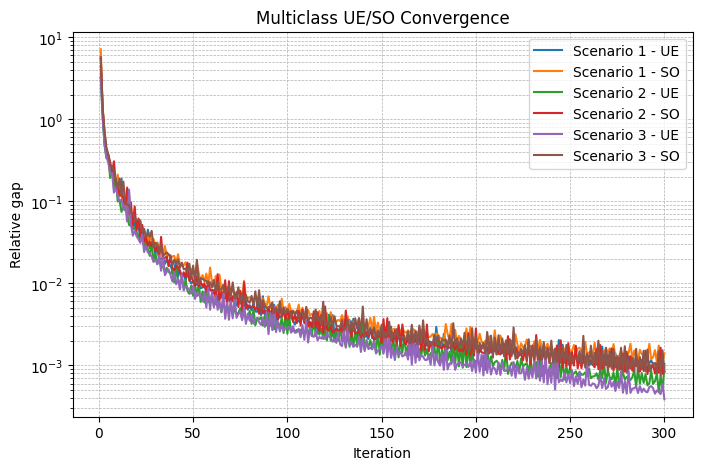

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for name, results in scenario_results.items():
    for label in ("UE", "SO"):
        history = results[label]["history"]
        if not history:
            continue
        iterations = [item["iteration"] for item in history]
        gaps = [max(item["gap"], 1e-12) for item in history]
        plt.semilogy(iterations, gaps, label=f"{name} - {label}")

plt.xlabel("Iteration")
plt.ylabel("Relative gap")
plt.title("Multiclass UE/SO Convergence")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()
